In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms

In [4]:
# download mnist data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

# create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)


In [5]:
# define model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)  # 28*28=784
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 classes

    def forward(self, x):
        # flatten input tensor
        x = x.view(x.shape[0], -1)

        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # add output layer
        x = F.log_softmax(self.fc3(x), dim=1)

        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create model
model = Net().to(device)

# create optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [7]:
# train model
epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # move tensors to device
        images, labels = images.to(device), labels.to(device)

        # clear gradients
        optimizer.zero_grad()

        # forward pass
        output = model(images)

        # calculate loss
        loss = F.nll_loss(output, labels)

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()

        running_loss += loss.item()

    else:
        print(f"Training loss: {running_loss/len(train_loader)}")

Training loss: 1.7481821932391064
Training loss: 0.5595246302579512
Training loss: 0.3937144729374314
Training loss: 0.3408025063669631
Training loss: 0.3098473443882043
Training loss: 0.287249199331188
Training loss: 0.2693581045833605
Training loss: 0.25391074511875855
Training loss: 0.23957082392500917
Training loss: 0.22687205348187672


In [8]:
# test model
test_loss = 0
accuracy = 0
with torch.no_grad():
    for images, labels in test_loader:
        # move tensors to device
        images, labels = images.to(device), labels.to(device)

        # forward pass
        output = model(images)

        # calculate loss
        test_loss += F.nll_loss(output, labels).item()

        # calculate accuracy
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

print(f"Test loss: {test_loss/len(test_loader)}")
print(f"Test accuracy: {accuracy/len(test_loader)}")

Test loss: 0.21591683031077596
Test accuracy: 0.9382961988449097


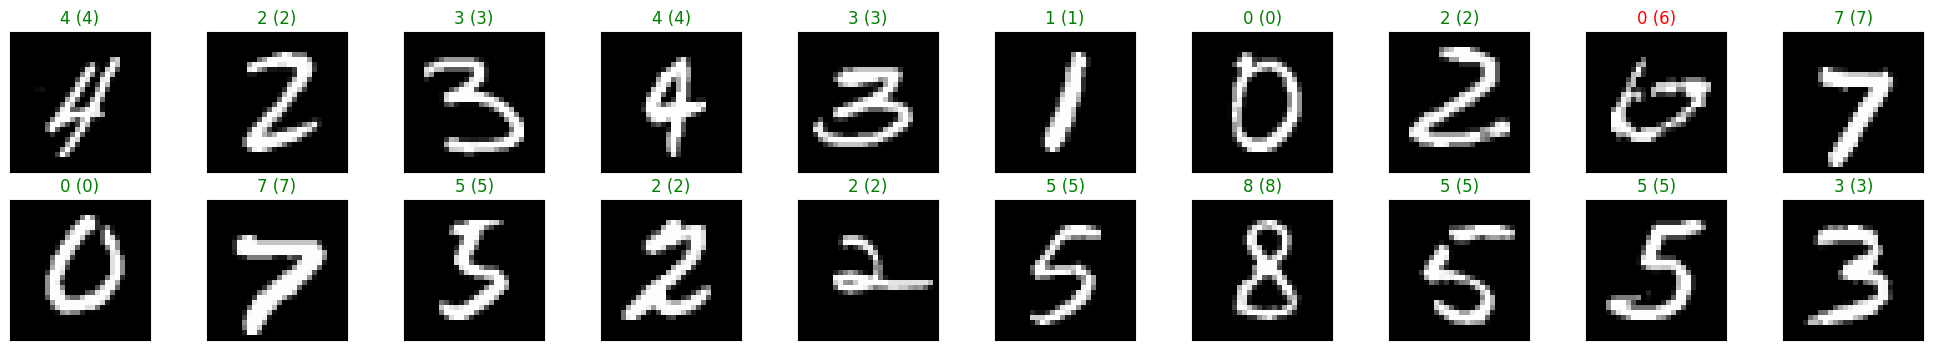

In [9]:
# show some examples
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(f"{preds[idx]} ({labels[idx]})",
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [11]:
# export model to onnx
torch.onnx.export(
    model,
    torch.from_numpy(images).to(device),
    "mnist.onnx",
    verbose=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},  # variable length axes
        "output": {0: "batch_size"},
    },
)


Exported graph: graph(%input : Float(*, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cuda:0),
      %fc1.weight : Float(128, 784, strides=[784, 1], requires_grad=1, device=cuda:0),
      %fc1.bias : Float(128, strides=[1], requires_grad=1, device=cuda:0),
      %fc2.weight : Float(64, 128, strides=[128, 1], requires_grad=1, device=cuda:0),
      %fc2.bias : Float(64, strides=[1], requires_grad=1, device=cuda:0),
      %fc3.weight : Float(10, 64, strides=[64, 1], requires_grad=1, device=cuda:0),
      %fc3.bias : Float(10, strides=[1], requires_grad=1, device=cuda:0)):
  %/Shape_output_0 : Long(4, strides=[1], device=cpu) = onnx::Shape[onnx_name="/Shape"](%input), scope: __main__.Net:: # /tmp/ipykernel_1984646/3576900102.py:11:0
  %/Constant_output_0 : Long(device=cpu) = onnx::Constant[value={0}, onnx_name="/Constant"](), scope: __main__.Net:: # /tmp/ipykernel_1984646/3576900102.py:11:0
  %/Gather_output_0 : Long(device=cpu) = onnx::Gather[axis=0, onnx_name="/Gather"](%